In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

import sklearn
from sklearn.datasets import fetch_openml
from sklearn.neural_network import MLPClassifier
import sklearn.metrics as skm
from sklearn import linear_model, preprocessing

In [2]:
def load_dataset(path):
    data=np.genfromtxt(path, skip_header=1)
    x, y = data[:,1:18], data[:,18]
    x=np.delete(x,[6,-2,-3,-4,],1)
    #cancello b_max,a_hard, a_ej, a_gw
    return x, y

In [3]:
ID = 234212
np.random.seed(ID)

In [4]:
X, y = load_dataset("dataset_3Body_NSC.dat")
print(X.shape, y.shape)

(100000, 13) (100000,)


In [5]:

index_2=np.where(y==2)[0]
y[index_2]=1
index_3=np.where(y==3)[0]
y[index_3]=2

In [6]:
#random permute the data and split into training and test 
'''
#crop
index_0=np.where(y==0)[0]
index_1=np.where(y==1)[0]
index_2=np.where(y==2)[0]


index=np.concatenate((index_0[:6000],index_1[:6000],index_2[:6000]))

X_train=X[index]
y_train=y[index]
permutation =  np.random.permutation(len(y_train))
X_train =X_train[permutation]
y_train=y_train[permutation]

index=np.concatenate((index_0[6000:],index_1[6000:],index_2[6000:]))

X_test=X[index]
y_test=y[index]
permutation = np.random.permutation(len(X_test))
X_test =X_test[permutation]
y_test=y_test[permutation]
'''
#crop



m_training = 40000
m_test = 60000

X_train = X[:m_training,:]
X_test = X[m_training:,:]
Y_train = y[0:m_training] 
Y_test = y[m_training:]



print("X_train shape:", X_train.shape,"X_test shape:", X_test.shape,"||","y_train shape:",  Y_train.shape,"y_test shape:", Y_test.shape)

labels, freqs = np.unique(Y_train, return_counts=True) 
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)

# standardize the input matrix
# the transformation is computed on training data and then used on all the 3 sets
scaler = preprocessing.StandardScaler().fit(X_train) 

np.set_printoptions(suppress=True) 
X_train =  scaler.transform(X_train)
print ("Mean of the training input data:", X_train.mean(axis=0))
print ("Std of the training input data:",X_train.std(axis=0))

X_test = scaler.transform(X_test)
print ("Mean of the test input data:", X_test.mean(axis=0))
print ("Std of the test input data:", X_test.std(axis=0))

X_train shape: (40000, 13) X_test shape: (60000, 13) || y_train shape: (40000,) y_test shape: (60000,)
Labels in training dataset:  [0. 1. 2.]
Frequencies in training dataset:  [21243 12173  6584]
Mean of the training input data: [-0.  0.  0. -0. -0. -0. -0.  0.  0.  0. -0.  0.  0.]
Std of the training input data: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean of the test input data: [-0.00118767 -0.00586706 -0.00904662  0.0028647  -0.00322578  0.00625288
 -0.00650798 -0.00340587  0.00682265  0.0049844  -0.00496855  0.00002301
 -0.00338806]
Std of the test input data: [0.99423356 0.98951539 0.9970769  1.01562995 0.99806231 1.02181177
 0.99774793 1.00508789 1.00033592 0.99840395 1.00030566 1.00368708
 0.76811384]


In [7]:
from mpl_toolkits.mplot3d import Axes3D

def plot_input(X_matrix, labels):
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    cmap = plt.cm.get_cmap('Accent', 4)
    im = ax.scatter(X_matrix[:,0], X_matrix[:,1], X_matrix[:,2], c=labels, cmap=cmap)
    im.set_clim(-0.5, 3.5)
    cbar=fig.colorbar(im, ticks=[0,1,2,3], orientation='vertical') 

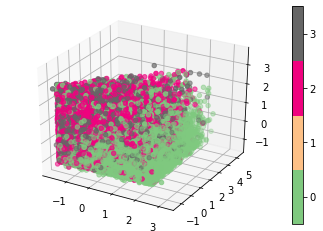

In [8]:
plot_input(X_train[:,:3],Y_train)
#masse giusto per un plot

In [82]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras import utils
from sklearn.utils import class_weight

class_weights=class_weight.compute_class_weight(class_weight="balanced",classes=np.unique(y), y=y)

class_weights = dict(zip(np.unique(y), class_weights))

'''
class_weight = {0: 1.,
                1: 1,
                2: 3.}
'''

METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision')
]



model = tf.keras.Sequential([
    tf.keras.Input(shape=(13,)),
    tf.keras.layers.Dense(25, activation='sigmoid'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 25)                350       
                                                                 
 dense_32 (Dense)            (None, 25)                650       
                                                                 
 dense_33 (Dense)            (None, 3)                 78        
                                                                 
Total params: 1,078
Trainable params: 1,078
Non-trainable params: 0
_________________________________________________________________


In [83]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [84]:
X_tensor=tf.convert_to_tensor(X_train, dtype=tf.float32)
y_tensor=tf.convert_to_tensor(Y_train, dtype=tf.float32)

from keras.utils import np_utils
dummy_y = np_utils.to_categorical(y_tensor)
#print(X_tensor) #shape=(1000, 13)
#print(y_tensor) #shape=(1000,)
print(model.output_shape)
history = model.fit(X_tensor, dummy_y, epochs=100, validation_split=0.1, batch_size=256)

(None, 3)
Epoch 1/100
141/141 [==============================] - 1s 3ms/step - loss: 0.8853 - accuracy: 0.5961 - val_loss: 0.7921 - val_accuracy: 0.6450
Epoch 2/100
141/141 [==============================] - 0s 2ms/step - loss: 0.7486 - accuracy: 0.6677 - val_loss: 0.7238 - val_accuracy: 0.6850
Epoch 3/100
141/141 [==============================] - 0s 2ms/step - loss: 0.7088 - accuracy: 0.6903 - val_loss: 0.7041 - val_accuracy: 0.6900
Epoch 4/100
141/141 [==============================] - 0s 2ms/step - loss: 0.6935 - accuracy: 0.6960 - val_loss: 0.6918 - val_accuracy: 0.6925
Epoch 5/100
141/141 [==============================] - 0s 2ms/step - loss: 0.6820 - accuracy: 0.7014 - val_loss: 0.6849 - val_accuracy: 0.6913
Epoch 6/100
141/141 [==============================] - 0s 2ms/step - loss: 0.6730 - accuracy: 0.7051 - val_loss: 0.6746 - val_accuracy: 0.6982
Epoch 7/100
141/141 [==============================] - 0s 2ms/step - loss: 0.6641 - accuracy: 0.7076 - val_loss: 0.6672 - val_accura

Epoch 58/100
141/141 [==============================] - 0s 2ms/step - loss: 0.5727 - accuracy: 0.7384 - val_loss: 0.5834 - val_accuracy: 0.7343
Epoch 59/100
141/141 [==============================] - 0s 2ms/step - loss: 0.5731 - accuracy: 0.7389 - val_loss: 0.5830 - val_accuracy: 0.7370
Epoch 60/100
141/141 [==============================] - 0s 2ms/step - loss: 0.5721 - accuracy: 0.7394 - val_loss: 0.5830 - val_accuracy: 0.7350
Epoch 61/100
141/141 [==============================] - 0s 2ms/step - loss: 0.5717 - accuracy: 0.7380 - val_loss: 0.5816 - val_accuracy: 0.7355
Epoch 62/100
141/141 [==============================] - 0s 2ms/step - loss: 0.5721 - accuracy: 0.7389 - val_loss: 0.5854 - val_accuracy: 0.7325
Epoch 63/100
141/141 [==============================] - 0s 2ms/step - loss: 0.5708 - accuracy: 0.7402 - val_loss: 0.5848 - val_accuracy: 0.7312
Epoch 64/100
141/141 [==============================] - 0s 2ms/step - loss: 0.5702 - accuracy: 0.7402 - val_loss: 0.5820 - val_accuracy:

In [85]:
dummy_y_test = np_utils.to_categorical(Y_test)
results = model.evaluate(X_test, dummy_y_test)

1875/1875 [==============================] - 2s 1ms/step - loss: 0.5776 - accuracy: 0.7345


In [73]:
results[1]

0.7355499863624573

In [58]:
'''
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier

y_clf=np_utils.to_categorical(y)

def createmodel(neurons,optimizer):
    model = tf.keras.Sequential([
    tf.keras.Input(shape=(13,)),
    tf.keras.layers.Dense(neurons, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
    ])
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

batch_size=[32, 64, 128, 256, 512]
optimizer=['adam','rmsprop','SGD']
units=[10, 25,75,200]

param_grid = dict(batch_size=batch_size, model__optimizer=optimizer, model__neurons=units)

model = KerasClassifier(model=createmodel, verbose=0)

clf = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring='accuracy', n_jobs=-1, cv=4, random_state=1)
search = clf.fit(X,y_clf)

best= search.best_params_
means= search.cv_results_['mean_test_score']
print(best, means)
''''''

/home/flavio/miniconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'model__optimizer': 'adam', 'model__neurons': 25, 'batch_size': 256} [0.53427 0.53427 0.53427 0.53427 0.53427 0.53427 0.53427 0.53427 0.26675
 0.53427]


In [61]:
params = search.cv_results_['params']
print(params)

[{'model__optimizer': 'adam', 'model__neurons': 25, 'batch_size': 256}, {'model__optimizer': 'SGD', 'model__neurons': 25, 'batch_size': 256}, {'model__optimizer': 'SGD', 'model__neurons': 10, 'batch_size': 32}, {'model__optimizer': 'adam', 'model__neurons': 10, 'batch_size': 512}, {'model__optimizer': 'SGD', 'model__neurons': 10, 'batch_size': 512}, {'model__optimizer': 'SGD', 'model__neurons': 75, 'batch_size': 256}, {'model__optimizer': 'adam', 'model__neurons': 200, 'batch_size': 128}, {'model__optimizer': 'SGD', 'model__neurons': 200, 'batch_size': 128}, {'model__optimizer': 'rmsprop', 'model__neurons': 25, 'batch_size': 256}, {'model__optimizer': 'adam', 'model__neurons': 25, 'batch_size': 128}]
